# Dense Pt. 2
---

Training models on the MFCCs, Enhanced Chroma, and Tempo features

*Unfortunately this is still only on the subset of data.  Parsing the whole songset has proven to be a much bigger resource chunk than I had though and consequently I am still left with my 240 song dataset.  In the previous notebook I had attempted to use the `multiprocessing` library to accelerate the process.  It took just under 4 hours to go through the whole songset with 8 cores running at 100% but when I went to use the data, the model wasn't learning anything and did the same or worse than baseline. I hope to solve this problem soon.*  

So as of 8/26/19:

My "final" model did ok, I was able to improve the initial accuracy and develop a dense NN that was a little more robust than the simpler ones.  There are many ways that to improve this, some I'd like to explore are using the Mel-freq spectrograms themselves (not coefficients) in a Convolutional2D Neural Network.  Convolutional1D layers could also be explored if I extract the features in the right dimension.  Additionally, I only included 1 'enhanced' feature that could be combined with other enhanced versions of the MFCCs or more to make the model more robust.  My final saved accuracy was 52% which will hopefully be improved once I am able to extract more robust features on the full dataset.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

sns.set_style(style="darkgrid")

In [6]:
df = pd.read_csv('features_df.csv')

In [7]:
df['label'].value_counts()

5    280
4    269
6    259
2    242
1    201
3    125
Name: label, dtype: int64

In [14]:
X = df.drop(['label'], axis=1)
y = df['label']

lb = LabelEncoder()
y = tf.keras.utils.to_categorical(lb.fit_transform(y), num_classes=6)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42, stratify=y)

In [16]:
ss = StandardScaler()

Xtrain_ss = ss.fit_transform(X_train)
Xtest_ss = ss.transform(X_test)

In [17]:
print(Xtrain_ss.shape)
print(Xtest_ss.shape)
print(y_train.shape)
print(y_test.shape)

(1169, 127)
(207, 127)
(1169, 6)
(207, 6)


In [201]:
model = Sequential()

model.add(Dense(512, input_shape=(127,),
                       activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.5))


model.add(Dense(256, activation='relu'))                      
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(256, activation='relu'))                     
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))                    
model.add(Dropout(0.5))


model.add(Dense(6, activation='softmax'))
                    

model.summary()

model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer='rmsprop')

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_618 (Dense)            (None, 512)               65536     
_________________________________________________________________
dropout_198 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_619 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_199 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_620 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_200 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_621 (Dense)            (None, 1024)            

In [202]:
hist_1 = model.fit(Xtrain_ss,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.1,
                   verbose=2)

Train on 1052 samples, validate on 117 samples
Epoch 1/50
1052/1052 - 1s - loss: 1.8474 - accuracy: 0.2044 - val_loss: 1.7441 - val_accuracy: 0.2991
Epoch 2/50
1052/1052 - 0s - loss: 1.7428 - accuracy: 0.2529 - val_loss: 1.6055 - val_accuracy: 0.3077
Epoch 3/50
1052/1052 - 0s - loss: 1.5970 - accuracy: 0.3403 - val_loss: 1.4681 - val_accuracy: 0.3590
Epoch 4/50
1052/1052 - 0s - loss: 1.5188 - accuracy: 0.3384 - val_loss: 1.4012 - val_accuracy: 0.3162
Epoch 5/50
1052/1052 - 0s - loss: 1.4382 - accuracy: 0.3669 - val_loss: 1.3566 - val_accuracy: 0.3333
Epoch 6/50
1052/1052 - 0s - loss: 1.3937 - accuracy: 0.3622 - val_loss: 1.3575 - val_accuracy: 0.3590
Epoch 7/50
1052/1052 - 0s - loss: 1.3368 - accuracy: 0.3812 - val_loss: 1.3216 - val_accuracy: 0.3761
Epoch 8/50
1052/1052 - 0s - loss: 1.3238 - accuracy: 0.3916 - val_loss: 1.3193 - val_accuracy: 0.4274
Epoch 9/50
1052/1052 - 0s - loss: 1.3175 - accuracy: 0.4097 - val_loss: 1.2844 - val_accuracy: 0.3333
Epoch 10/50
1052/1052 - 0s - loss: 

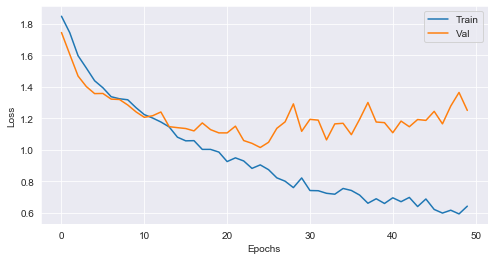

In [203]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))

plt.plot(hist_1.history['loss'], label='Train')
plt.plot(hist_1.history['val_loss'], label='Val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

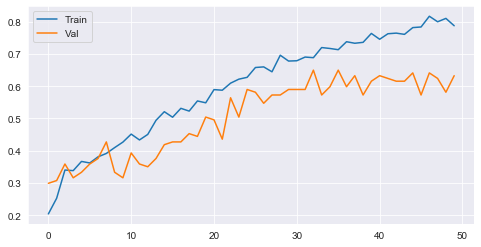

In [204]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))


plt.plot(hist_1.history['accuracy'], label='Train', )
plt.plot(hist_1.history['val_accuracy'], label='Val')
plt.legend();

In [205]:
model.evaluate(Xtest_ss, y_test, verbose=0)

[1.2854717843198546, 0.6086956]

In [194]:
predictions = model.predict(Xtest_ss)

In [28]:
np.savetxt("../data/D3_preds.npy", predictions, delimiter=",")

In [30]:
model.save("../data/.h5_files/D3_std_feats.h5")
model.save_weights("../data/.h5_files/D3_weights.h5")

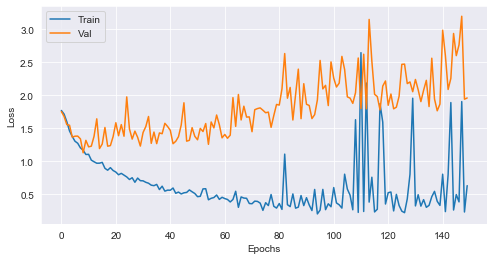

In [33]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))

plt.plot(hist_1.history['loss'], label='Train')
plt.plot(hist_1.history['val_loss'], label='Val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

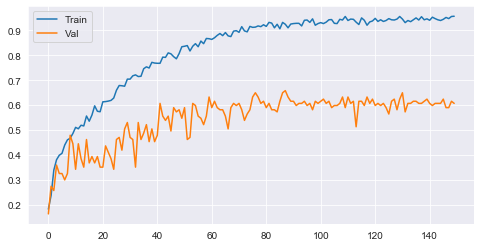

In [34]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))


plt.plot(hist_1.history['accuracy'], label='Train', )
plt.plot(hist_1.history['val_accuracy'], label='Val')
plt.legend();

In [156]:
Xtest_ss.shape

(207, 127)

In [35]:
model.evaluate(Xtest_ss, y_test, verbose=0)

[4.552611869314442, 0.6135266]

In [157]:
Xtest_reshaped = Xtest_ss.reshape(207, 127, 1)
Xtrain_reshaped = Xtrain_ss.reshape((1169, 127, 1))

In [171]:
Xtrain_reshaped[0]

array([[ 1.09716272],
       [ 1.05523333],
       [-1.04500102],
       [ 1.01255622],
       [-0.29916475],
       [-0.5185542 ],
       [-0.17610892],
       [-1.16619243],
       [-1.2372555 ],
       [-0.38424667],
       [-1.0864511 ],
       [-0.05586424],
       [-0.88564714],
       [-0.35952543],
       [-1.3164506 ],
       [-0.43859633],
       [-0.30078901],
       [-0.37426027],
       [-1.70466445],
       [-0.9259301 ],
       [-0.53870323],
       [-0.19971607],
       [-0.67446311],
       [-1.50108927],
       [-1.36924587],
       [-0.38621338],
       [ 1.0966437 ],
       [ 0.59803987],
       [-0.53136335],
       [-1.67326746],
       [-1.40734674],
       [-0.91030131],
       [ 0.32263397],
       [-0.05457698],
       [-0.41979561],
       [-0.73681823],
       [-0.91956583],
       [-1.05015278],
       [-0.13518345],
       [ 0.2937435 ],
       [ 1.26433874],
       [ 0.85771449],
       [ 1.12059674],
       [-1.12220256],
       [-1.90837096],
       [-1

This model performed slightly better than MFCCs, and was significantly less overfit.  I played around with neurons and dropout layers a bit while add a few more than I had in the very first model since there are more features to learn.  It helped with accuracy a bit and definitely helped with overfitting.  Since I never evaluated the original model I don't know if that would have actually performed well on unseen data.

In [303]:
cnn_model = Sequential()

cnn_model.add(Conv1D(32, 9, input_shape=(127,1), activation='relu'))

cnn_model.add(Conv1D(32, 9, activation='relu'))

cnn_model.add(Conv1D(32, 9, activation='relu'))

cnn_model.add(MaxPool1D(5))

cnn_model.add(Conv1D(32, 12, activation='relu'))


cnn_model.add(GlobalMaxPool1D())

cnn_model.add(Dense(6, activation='softmax'))

cnn_model.summary()

cnn_model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer='rmsprop')

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_125 (Conv1D)          (None, 119, 32)           320       
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 111, 32)           9248      
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 103, 32)           9248      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 20, 32)            0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 9, 32)             12320     
_________________________________________________________________
global_max_pooling1d_30 (Glo (None, 32)                0         
_________________________________________________________________
dense_267 (Dense)            (None, 6)               

In [304]:
hist_2 = cnn_model.fit(Xtrain_reshaped,
                   y_train,
                   epochs=100,
                   batch_size=64,
                   validation_split=0.1,
                   verbose=2)

Train on 1052 samples, validate on 117 samples
Epoch 1/100
1052/1052 - 1s - loss: 1.6983 - accuracy: 0.2681 - val_loss: 1.6579 - val_accuracy: 0.2821
Epoch 2/100
1052/1052 - 0s - loss: 1.5536 - accuracy: 0.3413 - val_loss: 1.5873 - val_accuracy: 0.2906
Epoch 3/100
1052/1052 - 0s - loss: 1.4540 - accuracy: 0.3831 - val_loss: 1.6046 - val_accuracy: 0.3333
Epoch 4/100
1052/1052 - 0s - loss: 1.3952 - accuracy: 0.4049 - val_loss: 1.6218 - val_accuracy: 0.3761
Epoch 5/100
1052/1052 - 0s - loss: 1.3709 - accuracy: 0.4173 - val_loss: 1.5868 - val_accuracy: 0.3162
Epoch 6/100
1052/1052 - 0s - loss: 1.3453 - accuracy: 0.4430 - val_loss: 1.6476 - val_accuracy: 0.3419
Epoch 7/100
1052/1052 - 0s - loss: 1.2840 - accuracy: 0.4525 - val_loss: 1.7245 - val_accuracy: 0.3162
Epoch 8/100
1052/1052 - 0s - loss: 1.2713 - accuracy: 0.4781 - val_loss: 1.8331 - val_accuracy: 0.2906
Epoch 9/100
1052/1052 - 0s - loss: 1.2506 - accuracy: 0.4639 - val_loss: 1.7061 - val_accuracy: 0.3077
Epoch 10/100
1052/1052 - 0

Epoch 80/100
1052/1052 - 0s - loss: 0.0888 - accuracy: 0.9753 - val_loss: 4.6538 - val_accuracy: 0.2991
Epoch 81/100
1052/1052 - 0s - loss: 0.0738 - accuracy: 0.9895 - val_loss: 4.6485 - val_accuracy: 0.3248
Epoch 82/100
1052/1052 - 0s - loss: 0.1380 - accuracy: 0.9648 - val_loss: 4.9144 - val_accuracy: 0.3077
Epoch 83/100
1052/1052 - 0s - loss: 0.0441 - accuracy: 0.9905 - val_loss: 4.7979 - val_accuracy: 0.2906
Epoch 84/100
1052/1052 - 0s - loss: 0.1473 - accuracy: 0.9629 - val_loss: 4.7071 - val_accuracy: 0.3077
Epoch 85/100
1052/1052 - 0s - loss: 0.0389 - accuracy: 0.9952 - val_loss: 4.6381 - val_accuracy: 0.2991
Epoch 86/100
1052/1052 - 0s - loss: 0.0598 - accuracy: 0.9914 - val_loss: 4.7486 - val_accuracy: 0.3162
Epoch 87/100
1052/1052 - 0s - loss: 0.1583 - accuracy: 0.9629 - val_loss: 4.7067 - val_accuracy: 0.3077
Epoch 88/100
1052/1052 - 0s - loss: 0.0895 - accuracy: 0.9772 - val_loss: 4.9293 - val_accuracy: 0.2650
Epoch 89/100
1052/1052 - 0s - loss: 0.0473 - accuracy: 0.9933 - 

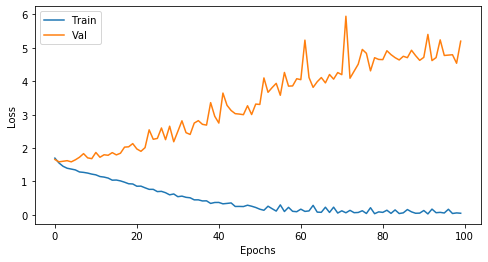

In [305]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))

plt.plot(hist_2.history['loss'], label='Train')
plt.plot(hist_2.history['val_loss'], label='Val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

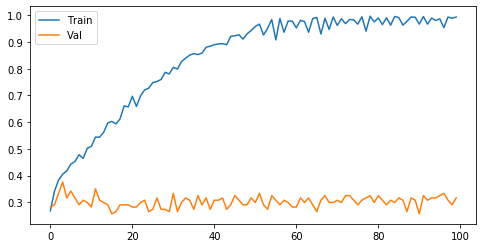

In [306]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))

plt.plot(hist_2.history['accuracy'], label='Train', )
plt.plot(hist_2.history['val_accuracy'], label='Val')
plt.legend();

In [307]:
cnn_model.evaluate(Xtest_reshaped, y_test, verbose=0)

[4.154709947281989, 0.42028984]

The Conv1D model has predicting power but not quite as much as the dense model for this data.  I imagine that has a lot to do with my lack of expert knowledge.  I tried to think about which size filters and convolutions would make sense but I still struggled to come up with a good logic behind it.  If I had more time I would go more in-depth with convolutional networks, including 2D.  

My guiding thought process was considering the 3 different features and how patterns might be recognized in a sequence of them.  There are the 112 mel-freqency coeffs, 12 pitch classes, and the tempo so I tried figuring out some sort of length that would be able to show a meaningful pattern and where convolutions should be longer or shorter.  I had some mild success with setting the lengths to 9 but I would need more time to experiment and see how the model reacts as well as do a deeper dive into the inner workings of each layer to get a better intuition.  Also since Conv1D are good for sequence data like time series, using something from the audio time series could be helpful (ie include more of the audio temporal features). 